<a href="https://colab.research.google.com/github/tmsandford/M33_Matching/blob/main/unWISE_PHATTER_match.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%%capture
!pip install --upgrade pip
!pip install vaex
!pip install -Iv ipython==7.0.0
!pip install astroquery
!sudo pip install numpy --upgrade --ignore-installed
!pip install mpld3

##### MAKE SURE TO 'RESTART RUNTIME' #####

In [1]:
import sys,os
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import vaex
import astropy.units as u

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/')
datadir = '/content/gdrive/My Drive/Colab Notebooks/'

Mounted at /content/gdrive


In [3]:
from astroquery.irsa import Irsa
from astropy.coordinates import SkyCoord
from astropy import units as u

Irsa.ROW_LIMIT = 100000

###Create a table of unWISE sources within the PHATTER footprint
unwise = Irsa.query_region("m33", catalog="unwise_2019", spatial="Polygon",
            polygon=[SkyCoord(ra=23.34,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.663,dec=30.488,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.663,dec=30.85,unit=(u.deg,u.deg),frame='icrs'),
                     SkyCoord(ra=23.34,dec=30.85,unit=(u.deg,u.deg),frame='icrs')])

In [4]:
###Select only relevant columns and remove entries with no W1 flux measurement

unwise = unwise['ra', 'dec', 'flux_1', 'flux_2']

unwise = unwise.filled(fill_value=0)

unwise = unwise[unwise['flux_1'] != 0]

#unwise = unwise.to_pandas()

In [5]:
###Function to convert flux measurements to W1 magnitude

def unwise_to_mag(flux):
  mag = 22.5 - 2.5 * np.log10(flux)
  return mag

In [6]:
unwise['w1_mag'], unwise['w2_mag'] = unwise_to_mag(unwise['flux_1']), unwise_to_mag(unwise['flux_2'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


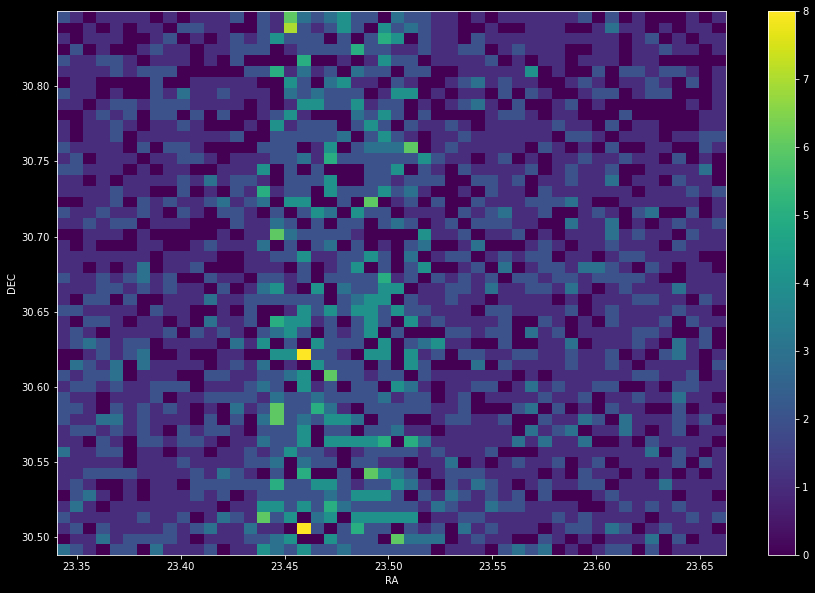

In [ ]:
plt.style.use('dark_background')
###Return a 2d histogram of all unWISE sources
plt.figure(num=1, figsize=(15,10))
unwise_hist,xbins,ybins,fig = plt.hist2d(unwise['ra'], unwise['dec'], 
                          bins=50);

plt.xlabel('RA'); 
plt.ylabel('DEC');                        
plt.colorbar();                          

In [ ]:
###Get indices of unWISE sources and add column to dataframe showing which bin each source is in

import reverse_indices_2d

unwise_ind = reverse_indices_2d.get_indices(unwise_hist, unwise['ra'], unwise['dec'], xbins, ybins)

unwise['bin'] = unwise_ind

In [ ]:
###Create a dataframe of PHATTER sources

phatter = vaex.open(datadir+'M33_full_matched.hdf5')
phatter.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15) & '
          '(F110W_CROWD < 2.25) & '
          '(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15) & '
          '(F160W_CROWD < 2.25) & (F160W_VEGA < 19)', name='IR_GST')

In [ ]:
phatter['F110W_F160W'] = phatter['F110W_VEGA'] - phatter['F160W_VEGA']
phatter.select('(F110W_F160W > 0.5) & IR_GST', name='col_cut')

###F160W to H conversion (using color conversions from https://arxiv.org/pdf/1109.6893.pdf (Dalcanton, 2018))
def convert_to_JH(f110w,f160w):
    j_h = 0.9418 + 0.841*(f110w-f160w-1.0) - 0.9053*(f110w-f160w-1.0)**2
    return j_h
def HST_to_2MASS(f110w,f160w):
    f160w_h = 0.2031 + 0.401*(convert_to_JH(f110w,f160w) - 0.9) + 0.3498*(convert_to_JH(f110w,f160w) - 0.9)**2
    h = f160w - f160w_h
    j = h + convert_to_JH(f110w,f160w)
    return j,h

###Define J and H for ph_data sources and add to dataframe

j_mag, h_mag = HST_to_2MASS(phatter['F110W_VEGA'], phatter['F160W_VEGA'])

phatter['J_Mag'], phatter['H_Mag'], phatter['J-H'] = j_mag, h_mag, j_mag - h_mag


###Convert J-H to H-W1 using parameters from fit, then get W1 mags for PHATTER sources
m_fit, b_fit = 0.84805331, -0.35556147

phatter['H-W1'] = m_fit*phatter['J-H'] + b_fit

phatter['W1_Mag'] = phatter['H_Mag'] - phatter['H-W1']

###Convert W1 magnitude to flux and add column to data
def m_to_flux(mag):
  result = 10**((mag - 22.5) / (-2.5))
  return result

phatter['W1_Flux'] = m_to_flux(phatter['W1_Mag'])

In [ ]:
ph_pandas = phatter.to_pandas_df(column_names=['RA', 'DEC', 'F110W_F160W', 'J-H', 'H-W1', 'F160W_VEGA', 'H_Mag', 'W1_Mag', 'W1_Flux'], selection='col_cut')

plt.figure(num=2)
ph_hist,_,_,_ = plt.hist2d(ph_pandas['RA'], ph_pandas['DEC'], bins=[xbins,ybins], density=False);
plt.close(2)
###Get indices of PHATTER sources and add column to dataframe showing which bin each source is in

ph_ind = reverse_indices_2d.get_indices(ph_hist, ph_pandas['RA'], ph_pandas['DEC'], xbins, ybins)
ph_pandas['BIN'] = ph_ind

/usr/local/lib/python3.7/dist-packages/vaex/arrow/numpy_dispatch.py:91: RuntimeWarning: overflow encountered in power
  result_data = op['op'](a_data, b_data)


In [ ]:
ph_data = vaex.from_pandas(ph_pandas)

In [ ]:
matches = []

for i, index in enumerate(unwise['bin']):
  bin_match = np.isin(ph_data.BIN.evaluate(), index)
                
  dist = np.sqrt( ((ph_data.RA.evaluate()[bin_match] - unwise['ra'][i])*np.cos(unwise['dec'][i] * np.pi / 180))**2 + 
               (ph_data.DEC.evaluate()[bin_match] - unwise['dec'][i])**2)
  
  wh, = np.where(dist <= 12/3600)

  try:
    match = np.argmin(ph_data.W1_Mag.evaluate()[bin_match][wh])
  
    flux_ratio = 10**(-0.4*ph_data.W1_Mag.evaluate()[bin_match][wh][match]) / 10**(-0.4*unwise['w1_mag'][i])

    match_color = ph_data.F110W_F160W.evaluate()[bin_match][wh][match]

    match_mag = ph_data.F160W_VEGA.evaluate()[bin_match][wh][match]
    
    match_ra, match_dec = ph_data.RA.evaluate()[bin_match][wh][match], ph_data.DEC.evaluate()[bin_match][wh][match]

    matches.append([flux_ratio, match_color, match_mag, match_ra, match_dec])
  except:
    matches.append([0.0, 0.0, 0.0, 0.0, 0.0])

In [ ]:
matches = np.array(matches)

In [ ]:
matched_only = np.where(matches[:,0] != 0)
final_match = matches[matched_only]

len(matches), len(final_match)

(3250, 2374)

In [ ]:
#fig, ax = plt.subplots(1,1)

#fig.set_size_inches(12,9)
#ax.hist(final_match[:,0], bins=50, color='teal', density=True);
#ax.set_title('Match Flux Ratios', color='orange', fontsize=20);

In [ ]:
#fig, ax = plt.subplots(1,1)
#plt.gca().invert_yaxis()

#fig.set_size_inches(20,16)

#ax.hist2d(phatter.F110W_F160W.evaluate(selection='IR_GST'), phatter.F160W_VEGA.evaluate(selection='IR_GST'),
#          bins=300, norm=mpl.colors.LogNorm(vmin=1,vmax=1e3), cmap='Greys');
#ax.scatter(final_match[:,1], final_match[:,2], s=30, c='red', marker='x', label='Matched PHATTER Sources');


#ax.set_xlabel('F110W-F160W Color', fontsize=20)
#ax.set_ylabel('F160W Magnitude', fontsize=20)

#ax.set_xlim(0.0,1.5);
#ax.set_ylim(14,19)
#ax.legend(loc='upper left', markerscale=2, shadow=True);

#ax.set_ylim(ax.get_ylim()[::-1]);



In [ ]:
#fig, ax = plt.subplots(1,1)

#fig.set_size_inches(12,9)

#ax.scatter(unwise['ra'], unwise['dec'], c='lightgrey', s=20, label='unWISE Source');
#ax.scatter(final_match[:,3], final_match[:,4], c='chartreuse', s=5, label='PHATTER Match');
#ax.legend(loc='best', shadow=True, markerscale=2);
#ax.set_xlabel('RA', fontsize=20);
#ax.set_ylabel('DEC', fontsize=20);

# Match with Looping Only

In [ ]:
loop_matches = []
flux_ratios = []

for i,source in enumerate(unwise):                
  dist, = np.where(np.sqrt( ((ph_data.RA.evaluate() - unwise['ra'][i])*np.cos(unwise['dec'][i] * np.pi / 180))**2 + 
               (ph_data.DEC.evaluate() - unwise['dec'][i])**2) <= 6/3600)

  try:
    flux_tot = np.sum(ph_data.W1_Flux.evaluate()[dist])

    match = np.argmax(ph_data.W1_Flux.evaluate()[dist] / flux_tot)
  
    flux_ratio = ph_data.W1_Flux.evaluate()[dist][match] / flux_tot
    
    match_color = ph_data.F110W_F160W.evaluate()[dist][match]

    match_mag = ph_data.F160W_VEGA.evaluate()[dist][match]
    
    match_ra, match_dec = ph_data.RA.evaluate()[dist][match], ph_data.DEC.evaluate()[dist][match]

    loop_matches.append([i, flux_ratio, match_color, match_mag, match_ra, match_dec])
    flux_ratios.append(ph_data.W1_Flux.evaluate()[dist] / flux_tot)
  except:
    loop_matches.append([i, 0.0, 0.0, 0.0, 0.0, 0.0])
    flux_ratios.append(0.0)

In [ ]:
loop_matches = np.array(loop_matches)
flux_ratios = np.array(flux_ratios)

matched_only = np.where(loop_matches[:,1] != 0.0)
final_loop_match = loop_matches[matched_only]

len(loop_matches), len(final_loop_match)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


(3250, 2342)

In [ ]:
ir, = np.where(unwise['flux_2'] != 0)
ir_matched = loop_matches[ir]
matched_only = np.where(ir_matched[:,1] != 0.0)
ir_matched = ir_matched[matched_only]

All Matches: 2342
Matches w/ W2 Detection: 1375


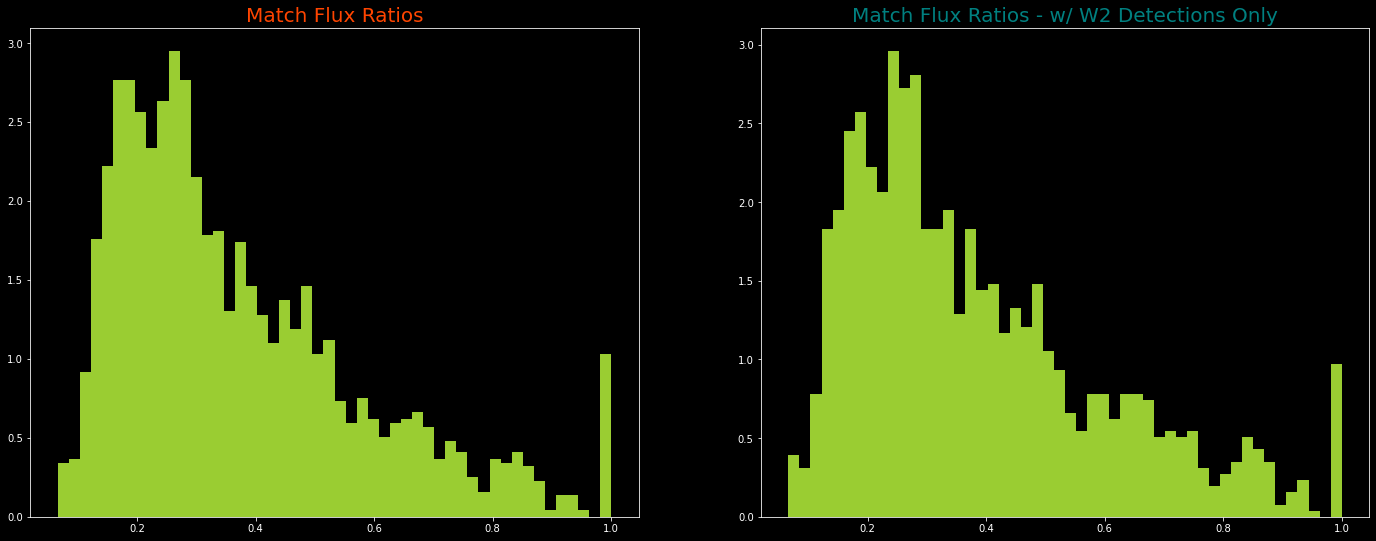

In [ ]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(24,9)
ax[0].hist(final_loop_match[:,1], bins=50, color='yellowgreen', density=True);
ax[0].set_title('Match Flux Ratios', color='orangered', fontsize=20);

ax[1].hist(ir_matched[:,1], bins=50, color='yellowgreen', density=True);
ax[1].set_title('Match Flux Ratios - w/ W2 Detections Only', color='teal', fontsize=20);

print('All Matches: ' + str(len(final_loop_match[:,1])))
print('Matches w/ W2 Detection: ' + str(len(ir_matched[:,1])))

In [ ]:
less_flux, = np.where(final_loop_match[:,1] <= 0.5)
sample = np.random.randint(0, 50)

#fig, ax = plt.subplots(10,5)
#fig.set_size_inches(20,48)


#for axx in ax:
#ax[0,0].hist(flux_ratios[less_flux][sample][0]);

flux_ratios[less_flux]

array([0.0, 0.0, 0.0, ...,
       array([0.40950844, 0.2204926 , 0.14144472, 0.22855424]),
       array([0.48280976, 0.0483325 , 0.12957515, 0.0902401 , 0.0818113 ,
              0.04644252, 0.05369294, 0.03561728, 0.03147845])           ,
       array([0.12238636, 0.15337091, 0.13399368, 0.11103315, 0.10641761,
              0.08097184, 0.08982836, 0.04074075, 0.04121282, 0.03716983,
              0.04514134, 0.03773335])                                   ],
      dtype=object)

In [ ]:
yticks = np.arange(14,19,0.25)
xticks = np.arange(0.5,1.5, 0.05)

In [ ]:
verts_1 = [(0.975, 18.2), (0.95, 17.0), (0.95, 16.3), (1.05, 16.0), (1.1,16.0), (1.2,16.25),
           (1.15, 16.75), (1.25, 17.33), (1.25, 18.0), (1.05, 18.5), (0.975, 18.2)]
codes_1 = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, 
           Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]

In [ ]:
verts_2 = [(0.93, 17.0), (0.85, 17.0), (0.86, 14.5), (1.0, 14.5), (1.0, 15.25), (0.95, 16.25), (0.93, 17.0)]
codes_2 = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]

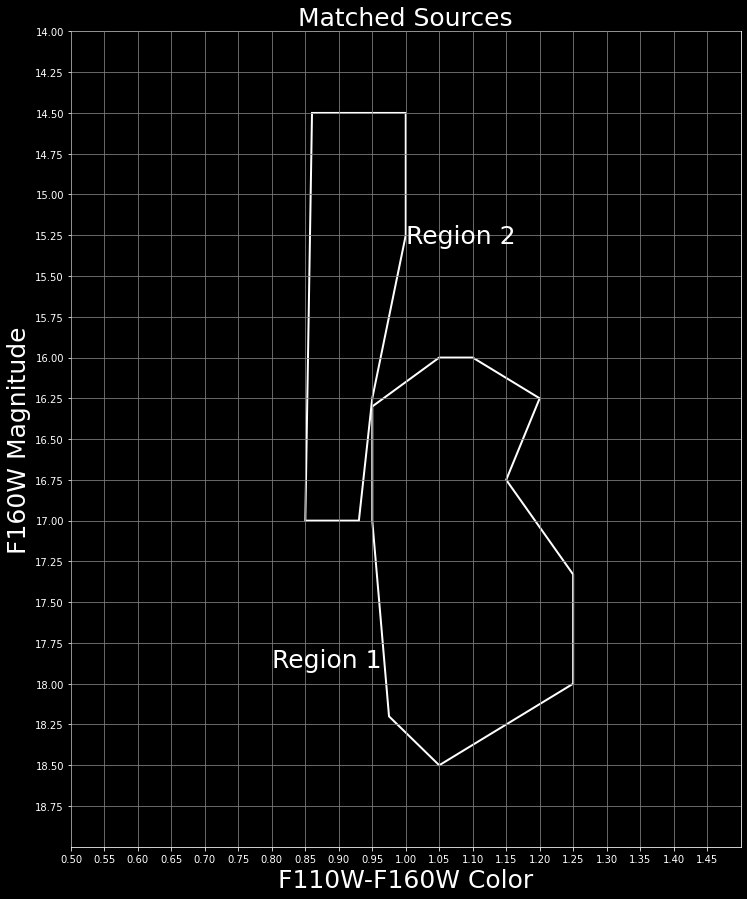

In [ ]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,15)

#ax.hist2d(phatter.F110W_F160W.evaluate(selection='IR_GST'), phatter.F160W_VEGA.evaluate(selection='IR_GST'),
#          bins=300, norm=mpl.colors.LogNorm(vmin=1,vmax=100), cmap='Greys');
ax.scatter(final_loop_match[:,1], final_loop_match[:,2], s=30, c='darkviolet', marker='x', label='Matched PHATTER Sources');


ax.set_xlabel('F110W-F160W Color', fontsize=25)
ax.set_ylabel('F160W Magnitude', fontsize=25)

ax.set_xlim(0.5,1.5);
ax.set_ylim(14,19)
ax.set_title('Matched Sources', fontsize=25, c='white')

ax.set_ylim(ax.get_ylim()[::-1]);

path_1 = Path(verts_1, codes_1)
path_2 = Path(verts_2, codes_2)
patch_1 = patches.PathPatch(path_1, facecolor='none', edgecolor='white', lw=2)
patch_2 = patches.PathPatch(path_2, facecolor='none', edgecolor='white', lw=2)
ax.add_patch(patch_1);
ax.add_patch(patch_2);
plt.xticks(xticks)
plt.yticks(yticks)
ax.grid(c='grey')
ax.set_axisbelow(False)
plt.text(1.0, 15.3, 'Region 2', fontsize=25, color='white');
plt.text(0.8, 17.9, 'Region 1', fontsize=25, color='white');

In [ ]:
reg1, = np.where(path_1.contains_points(np.vstack([final_loop_match[:,1], final_loop_match[:,2]]).T))
reg2, = np.where(path_2.contains_points(np.vstack([final_loop_match[:,1], final_loop_match[:,2]]).T))

In [ ]:
reg1_ra, reg1_dec = final_loop_match[reg1][:,3], final_loop_match[reg1][:,4]
reg2_ra, reg2_dec = final_loop_match[reg2][:,3], final_loop_match[reg2][:,4]
ph_ra, ph_dec = phatter.RA.evaluate(selection='IR_GST'), phatter.DEC.evaluate(selection='IR_GST')

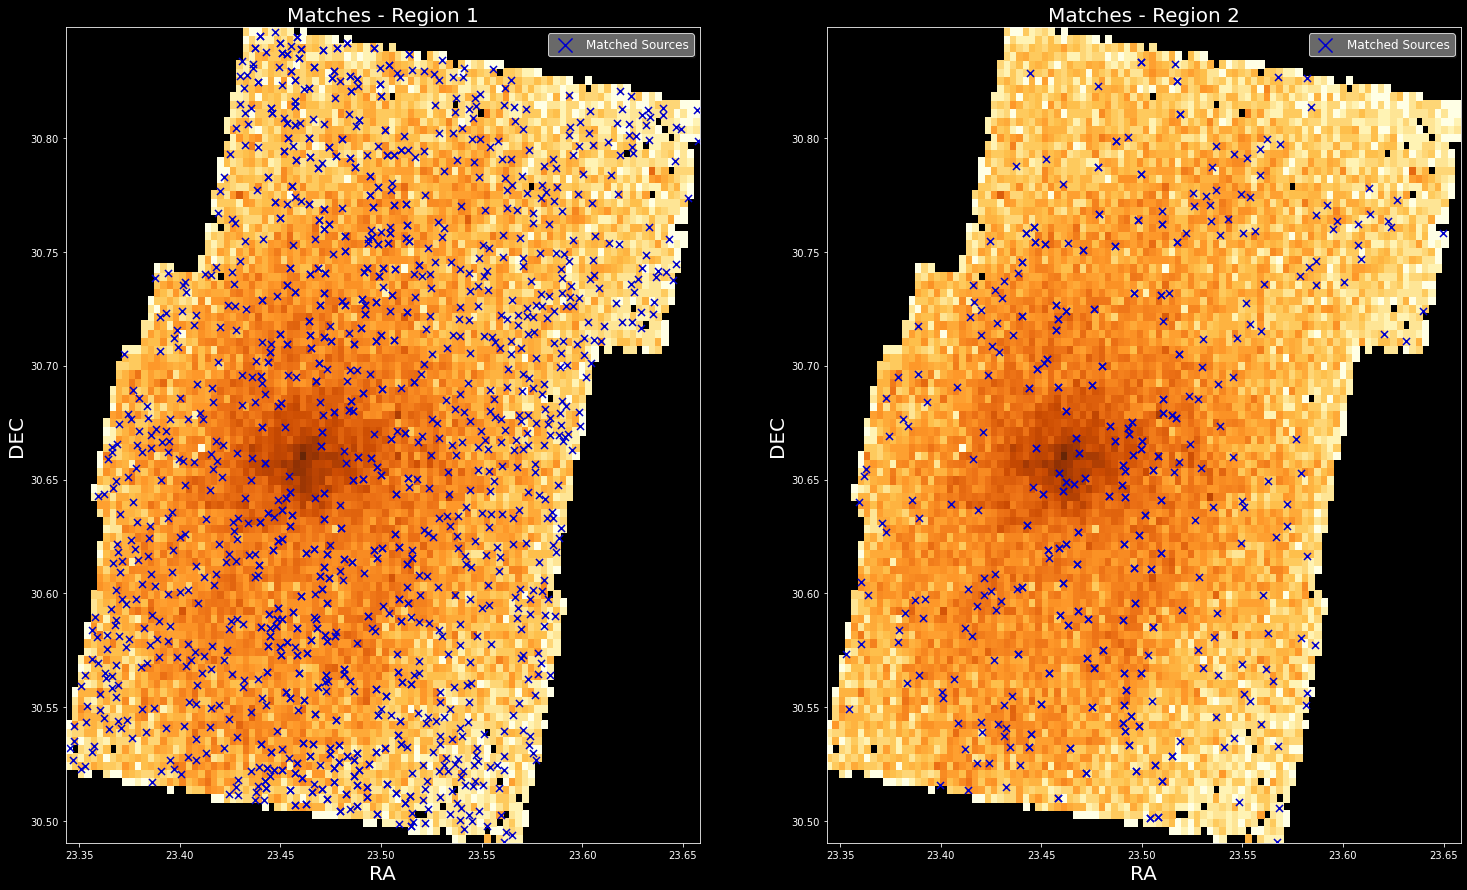

In [ ]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(25,15)

ax[0].hist2d(ph_ra, ph_dec, bins=100, norm=mpl.colors.LogNorm(vmin=1,vmax=100), cmap='YlOrBr')
ax[0].scatter(reg1_ra, reg1_dec, s=50, c='mediumblue', marker='x', label='Matched Sources');

ax[1].hist2d(ph_ra, ph_dec, bins=100, norm=mpl.colors.LogNorm(vmin=1,vmax=100), cmap='YlOrBr')
ax[1].scatter(reg2_ra, reg2_dec, s=50, c='mediumblue', marker='x', label='Matched Sources');

ax[0].set_title('Matches - Region 1', fontsize=20, color='white')
ax[1].set_title('Matches - Region 2', fontsize=20, color='white')
ax[0].set_xlabel('RA', fontsize=20)
ax[1].set_xlabel('RA', fontsize=20)
ax[0].set_ylabel('DEC', fontsize=20)
ax[1].set_ylabel('DEC', fontsize=20)



ax[0].legend(shadow=True, loc='best', fontsize=12, markerscale=2, facecolor='dimgrey');
ax[1].legend(shadow=True, loc='best', fontsize=12, markerscale=2, facecolor='dimgrey');

In [ ]:
reg1_flux_rat, reg2_flux_rat = final_loop_match[reg1][:,0], final_loop_match[reg2][:,0]

In [ ]:
from scipy import stats

a1, mu1, sigma1 = stats.skewnorm.fit(reg1_flux_rat)
a2, mu2, sigma2 = stats.skewnorm.fit(reg2_flux_rat)
a, mu, sigma = stats.skewnorm.fit(final_loop_match[:,0])

x = np.linspace(0, 3.5, 1000)

fit1 = stats.skewnorm.pdf(x, a1, mu1, sigma1)
fit2 = stats.skewnorm.pdf(x, a1, mu2, sigma2)
fit = stats.skewnorm.pdf(x, a, mu, sigma)

In [ ]:
text1 = '\n'.join((
    r'$\mu=%.3f$' % (mu1, ),
    r'$\sigma=%.3f$' % (sigma1, ),
    r'$\mathrm{skew}=%.3f$' % (a1, )))
props = dict(boxstyle='round', facecolor='lightsteelblue', alpha=0.5)

text2 = '\n'.join((
    r'$\mu=%.3f$' % (mu2, ),
    r'$\sigma=%.3f$' % (sigma2, ),
    r'$\mathrm{skew}=%.3f$' % (a2, )))
props = dict(boxstyle='round', facecolor='lightsteelblue', alpha=0.5)

text = '\n'.join((
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sigma, ),
    r'$\mathrm{skew}=%.3f$' % (a, )))
props = dict(boxstyle='round', facecolor='lightsteelblue', alpha=0.5)

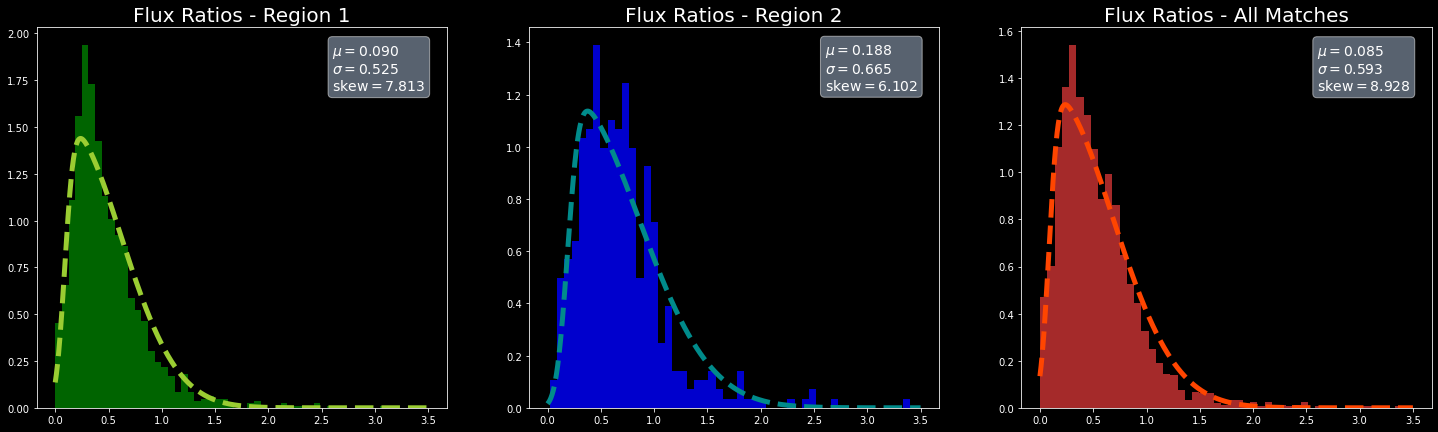

In [ ]:
fig, ax = plt.subplots(1,3)

fig.set_size_inches(25,7)

ax[0].hist(reg1_flux_rat, bins=50, color='darkgreen', density=True);
ax[0].plot(x, fit1, linestyle='--', c='yellowgreen', lw=5);
ax[0].set_title('Flux Ratios - Region 1', fontsize=20, c='white');
ax[0].text(2.6, 1.95, text1, fontsize=14, verticalalignment='top', bbox=props);

ax[1].hist(reg2_flux_rat, bins=50, color='mediumblue', density=True);
ax[1].plot(x, fit2, linestyle='--', c='darkcyan', lw=5);
ax[1].set_title('Flux Ratios - Region 2', fontsize=20, c='white');
ax[1].text(2.6, 1.4, text2, fontsize=14, verticalalignment='top', bbox=props);

ax[2].hist(final_loop_match[:,0], bins=50, color='brown', density=True);
ax[2].plot(x, fit, linestyle='--', c='orangered', lw=5);
ax[2].set_title('Flux Ratios - All Matches', color='white', fontsize=20);
ax[2].text(2.6, 1.55, text, fontsize=14, verticalalignment='top', bbox=props);

In [ ]:
reg1_less_flux, = np.where(reg1_flux_rat <= 1.0)
reg2_less_flux, = np.where(reg2_flux_rat <= 1.0)

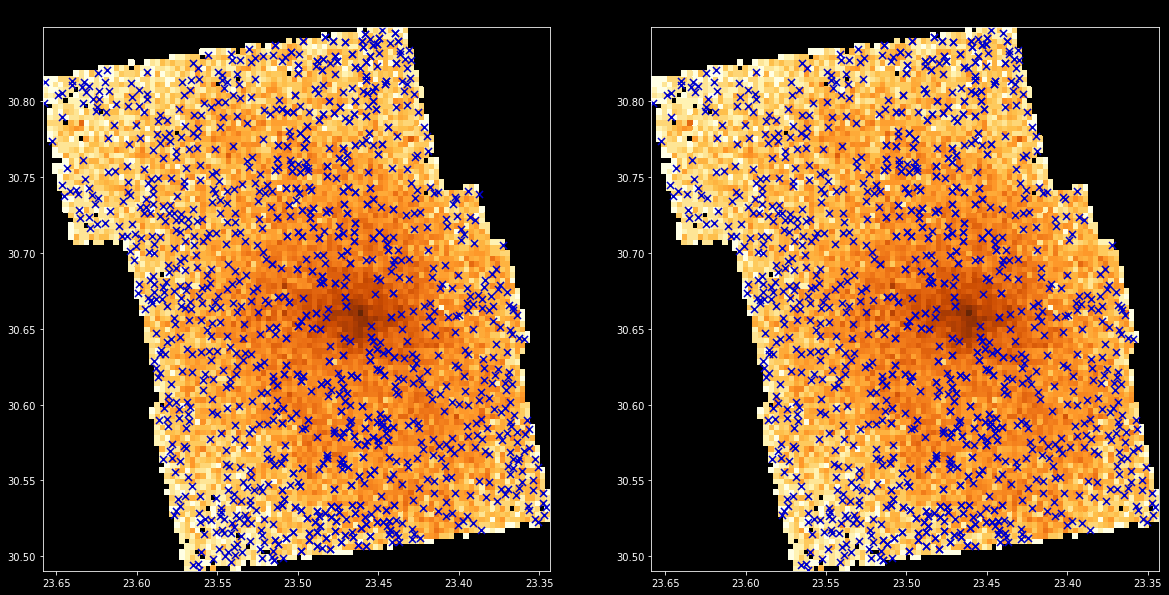

In [ ]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(20,10)

ax[0].hist2d(ph_ra, ph_dec, bins=100, norm=mpl.colors.LogNorm(vmin=1,vmax=100), cmap='YlOrBr');
ax[0].scatter(reg1_ra, reg1_dec, s=50, c='mediumblue', marker='x');
ax[0].set_title('All Region 1 Matches', fontsize=20, c='black');

ax[1].hist2d(ph_ra, ph_dec, bins=100, norm=mpl.colors.LogNorm(vmin=1,vmax=100), cmap='YlOrBr');
ax[1].scatter(reg1_ra[reg1_less_flux], reg1_dec[reg1_less_flux], s=50, c='mediumblue', marker='x');
ax[1].set_title('Flux Ratio <= 1.0 Matches', fontsize=20, c='black');

for axx in ax:
  axx.set_xlim(axx.get_xlim()[::-1])

(23.65, 23.35)

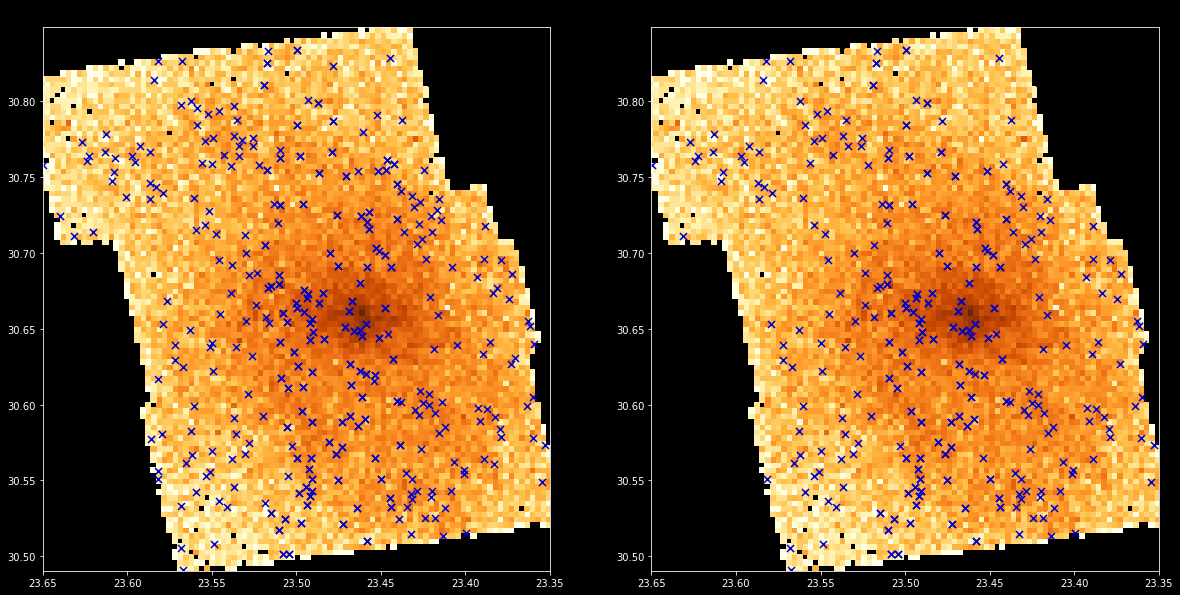

In [ ]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(20,10)

ax[0].hist2d(ph_ra, ph_dec, bins=100, norm=mpl.colors.LogNorm(vmin=1,vmax=100), cmap='YlOrBr');
ax[0].scatter(reg2_ra, reg2_dec, s=50, c='mediumblue', marker='x');
ax[0].set_title('All Region 2 Matches', fontsize=20, c='black');
ax[0].set_xlim(23.65,23.35)

ax[1].hist2d(ph_ra, ph_dec, bins=100, norm=mpl.colors.LogNorm(vmin=1,vmax=100), cmap='YlOrBr');
ax[1].scatter(reg2_ra[reg2_less_flux], reg2_dec[reg2_less_flux], s=50, c='mediumblue', marker='x');
ax[1].set_title('Flux Ratio <= 1.0 Matches', fontsize=20, c='black');
ax[1].set_xlim(23.65,23.35)

In [ ]:
region_2 = pd.DataFrame(final_loop_match[reg2][reg2_less_flux], columns=['flux_ratio', 'color', 'F160W_mag', 'ra', 'dec' ])
region_2

,flux_ratio,color,F160W_mag,ra,dec
0,0.495686,0.906,15.860,23.508042,30.501856
1,0.930221,0.910,15.740,23.458230,30.509976
2,0.514974,0.938,15.941,23.399432,30.515737
3,0.424757,0.899,15.439,23.509972,30.517582
4,0.445700,0.913,15.063,23.424153,30.525372
...,...,...,...,...,...
342,0.898508,0.872,16.967,23.562338,30.799755
343,0.455304,0.945,15.650,23.584199,30.813488
344,0.967476,0.939,16.096,23.499708,30.833226
345,0.918803,0.929,16.624,23.567280,30.490724


(23.65, 23.35)

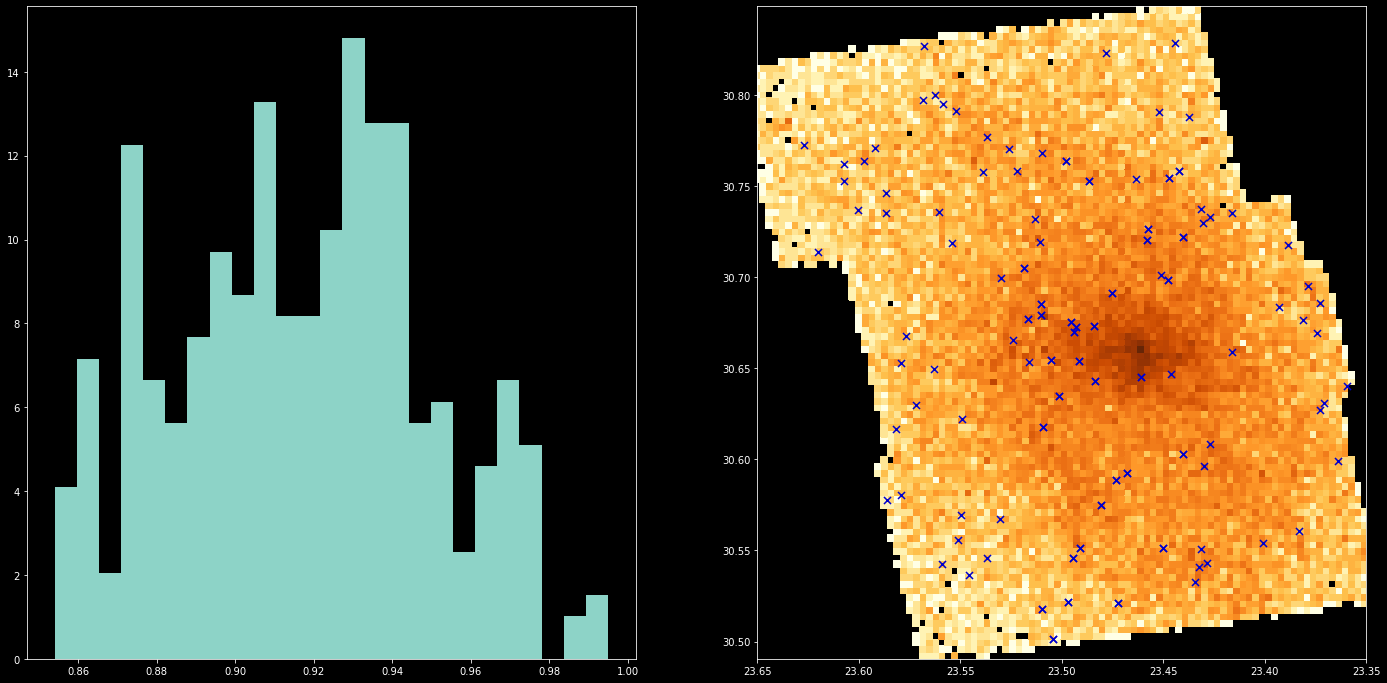

In [ ]:
reg2_col = final_loop_match[reg2][:,1]
reg2_size = final_loop_match[reg2][:,0]
col = np.where((reg2_col < 0.9))#& (reg2_col > 0.89))

fig, ax = plt.subplots(1,2)
fig.set_size_inches(24,12)

ax[0].hist(region_2['color'], bins=25, density=True);

ax[1].hist2d(ph_ra, ph_dec, bins=100, norm=mpl.colors.LogNorm(vmin=1,vmax=100), cmap='YlOrBr');
ax[1].scatter(reg2_ra[col], reg2_dec[col], s=50, c='mediumblue', marker='x');
ax[1].set_xlim(23.65,23.35)


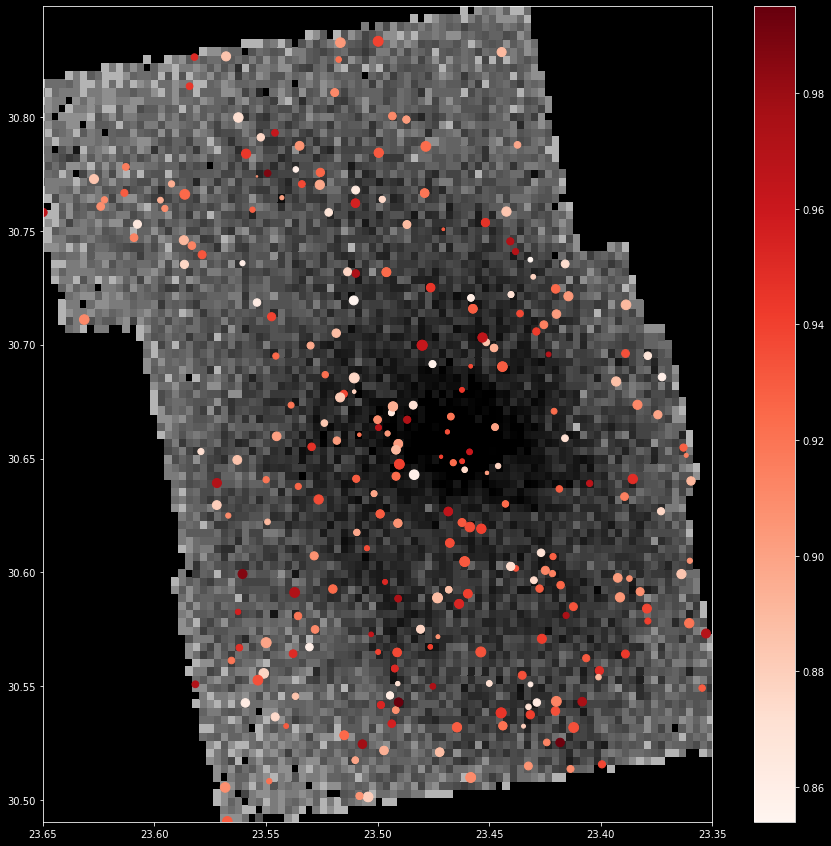

In [ ]:
plt.style.use('dark_background')
cmap = plt.cm.get_cmap('Reds')

fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,15)

ax.hist2d(ph_ra, ph_dec, bins=100, norm=mpl.colors.LogNorm(vmin=0.1,vmax=30), cmap='Greys');
ax.set_xlim(23.65, 23.35)
colors = ax.scatter(reg2_ra[reg2_less_flux], reg2_dec[reg2_less_flux], c=reg2_col[reg2_less_flux], cmap=cmap, s=reg2_size[reg2_less_flux]*100);
plt.colorbar(colors);

####Make this interactive so range of flux ratios can be displayed

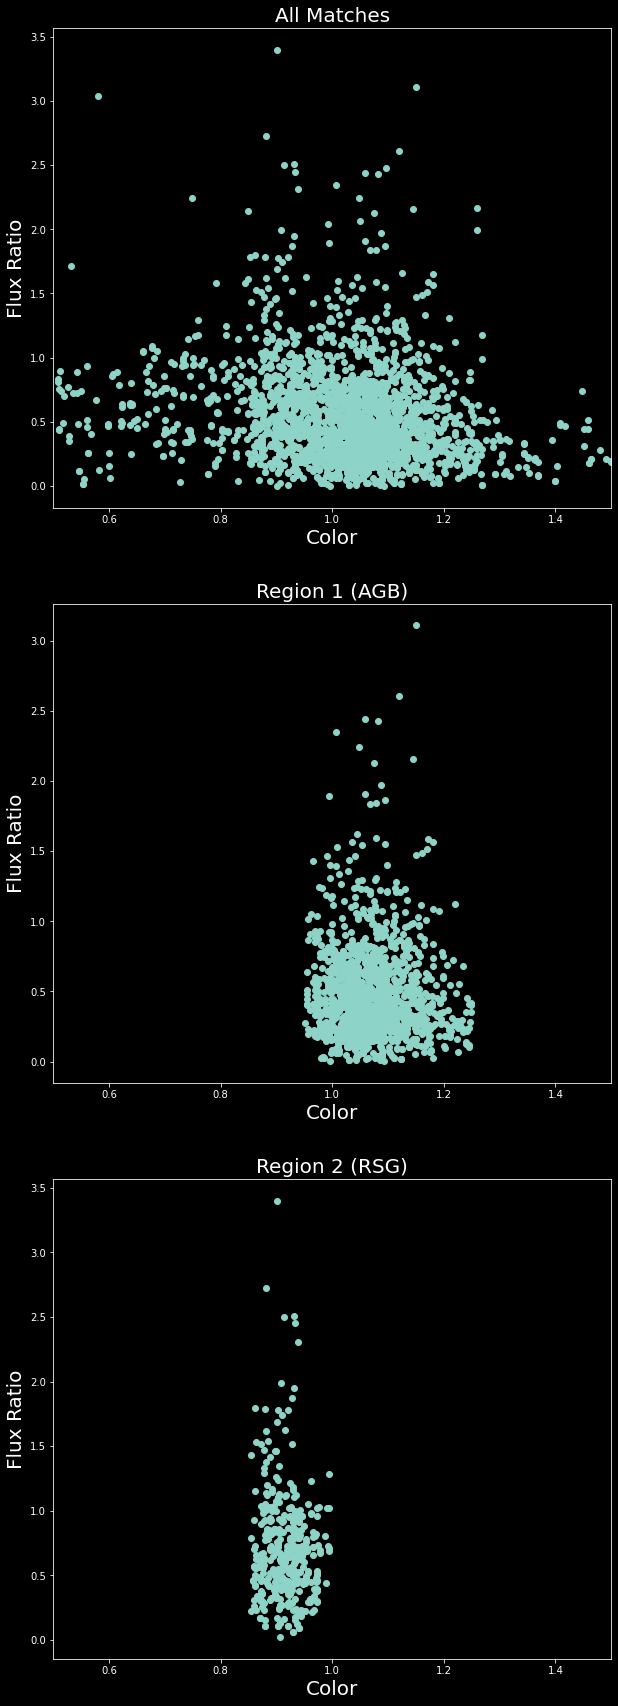

In [ ]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(10,30)

ax[0].scatter(final_loop_match[:,1], final_loop_match[:,0])
ax[0].set_title('All Matches', fontsize=20);
ax[0].set_xlabel('Color', fontsize=20);
ax[0].set_ylabel('Flux Ratio', fontsize=20);
ax[0].set_xlim(0.5,1.5);

ax[1].scatter(final_loop_match[reg1][:,1], final_loop_match[reg1][:,0])
ax[1].set_title('Region 1 (AGB)', fontsize=20);
ax[1].set_xlabel('Color', fontsize=20);
ax[1].set_ylabel('Flux Ratio', fontsize=20);
ax[1].set_xlim(0.5,1.5);

ax[2].scatter(final_loop_match[reg2][:,1], final_loop_match[reg2][:,0])
ax[2].set_title('Region 2 (RSG)', fontsize=20);
ax[2].set_xlabel('Color', fontsize=20);
ax[2].set_ylabel('Flux Ratio', fontsize=20);
ax[2].set_xlim(0.5,1.5);